#### 06 - BERT baseline for fashion vs non-fashion

This notebook fine-tunes a transformer-based classifier (BERT) on the
same cleaned dataset and time-aware splits used for the TF-IDF + logistic baseline:

- Input text: `product_text_norm`
- Labels: `label` (0 = non-fashion, 1 = fashion)
- Splits: `train`, `val`, `test` from `products_with_splits.parquet`

We will:
1. Load the processed dataset and splits.
2. Tokenize texts with a pre-trained transformer tokenizer.
3. Fine-tune the model with Hugging Face `Trainer`.
4. Plot training and validation loss curves to check for overfitting.
5. Evaluate on validation and test and later tune a probability threshold (as we did for logistic regression).

In [1]:
# Set up project paths, imports, and load products_with_splits

from pathlib import Path
import sys
import pandas as pd

# 1) Find project root (folder containing "src") and add src to sys.path
cwd = Path.cwd()
project_root = None
for path in [cwd, *cwd.parents]:
    if (path / "src").is_dir():
        project_root = path
        break

if project_root is None:
    raise FileNotFoundError("Could not find project root containing 'src' folder.")

SRC_DIR = project_root / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from config import PROCESSED_DATA_DIR

print("Project root:", project_root)
print("PROCESSED_DATA_DIR:", PROCESSED_DATA_DIR)

# 2) Load processed dataset with splits
data_path = PROCESSED_DATA_DIR / "products_with_splits.parquet"
df = pd.read_parquet(data_path)

print("Full dataset shape:", df.shape)
print("\nSplits:")
print(df["split"].value_counts().sort_index())

print("\nLabels:")
print(df["label"].value_counts().sort_index())

df[["product_text_raw", "product_text_norm", "label", "split"]].head(10)

Project root: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation
PROCESSED_DATA_DIR: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/processed
Full dataset shape: (19767, 10)

Splits:
split
test      2544
train    13961
val       3262
Name: count, dtype: int64

Labels:
label
0     3165
1    16602
Name: count, dtype: int64


,product_text_raw,product_text_norm,label,split
0,001B 3000A Car Jump Starter Battery Pack (up t...,001b 3000a car jump starter battery pack up to...,0,train
1,"012 Jump Starter Battery Pack, 4000A Peak Car ...",012 jump starter battery pack 4000a peak car b...,0,train
2,1/2 Ct Diamond Stud Earrings 14k Yellow Gold F...,1 2 ct diamond stud earrings 14k yellow gold f...,1,test
3,1-2 Pairs 925 Sterling Silver Mens Earrings Cu...,1 2 pairs 925 sterling silver mens earrings cu...,1,train
4,"1/2"""" x 18"""" Zirconia Sanding Belts for Belt S...",1 2 x 18 zirconia sanding belts for belt sande...,0,train
5,"1.5 Gram x 50 Vial Convenient Super Glue, Wegl...",1 5 gram x 50 vial convenient super glue wegla...,0,train
6,"1/6 Scale Female Clothes, Female Black Leather...",1 6 scale female clothes female black leather ...,1,train
7,"1/6 Scale Female Clothes, Female Sports Underw...",1 6 scale female clothes female sports underwe...,1,train
8,"1/6 Scale Female Clothes, Female Sports Underw...",1 6 scale female clothes female sports underwe...,1,train
9,1.75mm Normal PLA 4 Most Basic Colors Bundle P...,1 75mm normal pla 4 most basic colors bundle p...,0,train


In [2]:
# Create train / val / test DataFrames for BERT fine-tuning

df_train = df[df["split"] == "train"].copy()
df_val   = df[df["split"] == "val"].copy()
df_test  = df[df["split"] == "test"].copy()

print("Shapes:")
print("  train:", df_train.shape)
print("  val  :", df_val.shape)
print("  test :", df_test.shape)

def print_class_balance(name, subdf):
    counts = subdf["label"].value_counts().sort_index()
    pct = subdf["label"].value_counts(normalize=True).sort_index() * 100
    print(f"\nClass balance in {name} (0=non-fashion, 1=fashion):")
    for k in counts.index:
        print(f"  label={k}: {counts[k]} rows ({pct[k]:.2f}%)")

print_class_balance("train", df_train)
print_class_balance("val", df_val)
print_class_balance("test", df_test)

df_train[["product_text_raw", "product_text_norm", "label"]].head(5)

Shapes:
  train: (13961, 10)
  val  : (3262, 10)
  test : (2544, 10)

Class balance in train (0=non-fashion, 1=fashion):
  label=0: 2246 rows (16.09%)
  label=1: 11715 rows (83.91%)

Class balance in val (0=non-fashion, 1=fashion):
  label=0: 474 rows (14.53%)
  label=1: 2788 rows (85.47%)

Class balance in test (0=non-fashion, 1=fashion):
  label=0: 445 rows (17.49%)
  label=1: 2099 rows (82.51%)


,product_text_raw,product_text_norm,label
0,001B 3000A Car Jump Starter Battery Pack (up t...,001b 3000a car jump starter battery pack up to...,0
1,"012 Jump Starter Battery Pack, 4000A Peak Car ...",012 jump starter battery pack 4000a peak car b...,0
3,1-2 Pairs 925 Sterling Silver Mens Earrings Cu...,1 2 pairs 925 sterling silver mens earrings cu...,1
4,"1/2"""" x 18"""" Zirconia Sanding Belts for Belt S...",1 2 x 18 zirconia sanding belts for belt sande...,0
5,"1.5 Gram x 50 Vial Convenient Super Glue, Wegl...",1 5 gram x 50 vial convenient super glue wegla...,0


#### BERT model and tokenizer

We use the `bert-base-uncased` checkpoint from Hugging Face. The tokenizer will turn
`product_text_norm` strings into input IDs and attention masks for BERT. Product
titles are short, so we cap sequence length at 64 tokens.

In [3]:
from transformers import AutoTokenizer

# Choose the BERT checkpoint
MODEL_NAME = "bert-base-uncased"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LENGTH = 64  # max tokens per product title (truncates very long titles)

print("Using model:", MODEL_NAME)
print("Tokenizer vocab size:", tokenizer.vocab_size)
print("Max length:", MAX_LENGTH)

# Quick sanity check on a couple of sample texts
for txt in df_train["product_text_norm"].head(3).tolist():
    enc = tokenizer(
        txt,
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
    )
    print("\nSample text:", txt)
    print("input_ids length:", len(enc["input_ids"]))

/Users/ramana/anaconda3/envs/fashion-bert/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using model: bert-base-uncased
Tokenizer vocab size: 30522
Max length: 64

Sample text: 001b 3000a car jump starter battery pack up to 9 0l gas and 7 0l diesel engine 12v car battery charger jump box with usb 3 0 power bank
input_ids length: 64

Sample text: 012 jump starter battery pack 4000a peak car battery charger jump starter for up to 10 0l gas or 8 0l diesel engine 12v car jumper starter portable with full lcd screen led light usb
input_ids length: 64

Sample text: 1 2 pairs 925 sterling silver mens earrings cubic zirconia halo stud earrings for men 18k gold plated heart round square cut cz stud earrings set for women men
input_ids length: 64


	•	Converts each split into a Hugging Face Dataset with text and label.
	•	Runs the BERT tokenizer on all texts with padding/truncation to MAX_LENGTH.
	•	Renames label → labels because Trainer expects that column.
	•	Shows a sample tokenized item so you can see what BERT will receive.

In [4]:
# Build Hugging Face Datasets from the pandas splits and tokenize them

from datasets import Dataset

# Create base datasets with 'text' and 'label' columns
train_ds = Dataset.from_pandas(
    df_train[["product_text_norm", "label"]].rename(columns={"product_text_norm": "text"})
)
val_ds = Dataset.from_pandas(
    df_val[["product_text_norm", "label"]].rename(columns={"product_text_norm": "text"})
)
test_ds = Dataset.from_pandas(
    df_test[["product_text_norm", "label"]].rename(columns={"product_text_norm": "text"})
)

print("Raw HF datasets:")
print("  train:", train_ds)
print("  val  :", val_ds)
print("  test :", test_ds)

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
    )

# Apply tokenizer
train_ds_tok = train_ds.map(tokenize_batch, batched=True, remove_columns=["text", "__index_level_0__"])
val_ds_tok   = val_ds.map(tokenize_batch, batched=True, remove_columns=["text", "__index_level_0__"])
test_ds_tok  = test_ds.map(tokenize_batch, batched=True, remove_columns=["text", "__index_level_0__"])

# Set the format so Trainer gets tensors and labels
train_ds_tok = train_ds_tok.rename_column("label", "labels")
val_ds_tok   = val_ds_tok.rename_column("label", "labels")
test_ds_tok  = test_ds_tok.rename_column("label", "labels")

print("\nTokenized HF datasets:")
print("  train_tok:", train_ds_tok)
print("  val_tok  :", val_ds_tok)
print("  test_tok :", test_ds_tok)

# Inspect one tokenized example
first_example = train_ds_tok[0]
print("\nExample tokenized item keys:", first_example.keys())
print("input_ids length:", len(first_example["input_ids"]))
print("label:", first_example["labels"])

Raw HF datasets:
  train: Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 13961
})
  val  : Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 3262
})
  test : Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 2544
})


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Map: 100%|██████████| 2544/2544 [00:00<00:00, 39503.72 examples/s]


Tokenized HF datasets:
  train_tok: Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 13961
})
  val_tok  : Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3262
})
  test_tok : Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2544
})

Example tokenized item keys: dict_keys(['labels', 'input_ids', 'token_type_ids', 'attention_mask'])
input_ids length: 64
label: 0


#### BERT sequence classification setup

We now:
- load `bert-base-uncased` as a sequence classification model with 2 labels,
- define evaluation metrics (accuracy, precision, recall, F1 for "fashion" = label 1),
- configure Hugging Face `Trainer` to fine-tune BERT on the train split and evaluate on the val split.

In [5]:
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os

# 1) Load BERT classifier (2 labels)
id2label = {0: "non-fashion", 1: "fashion"}
label2id = {"non-fashion": 0, "fashion": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
)

# 2) Metrics: treat label 1 ("fashion") as the positive class
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary", pos_label=1
    )

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }

# 3) Data collator (handles padding; we already use fixed length, so this is simple)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 4) Training arguments
bert_output_dir = project_root / "models" / "bert_fashion"
os.makedirs(bert_output_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir=str(bert_output_dir),
    evaluation_strategy="epoch",      # run eval at end of each epoch
    save_strategy="epoch",            # save checkpoint each epoch
    learning_rate=2e-5,               # standard BERT fine-tuning LR
    per_device_train_batch_size=16,   # adjust if you hit memory issues
    per_device_eval_batch_size=32,
    num_train_epochs=3,               # start with 2–3 epochs
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    save_total_limit=2,               # keep last 2 checkpoints
    report_to="none",                 # no wandb/tensorboard by default
)

# 5) Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tok,
    eval_dataset=val_ds_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Trainer set up. Ready to fine-tune BERT.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/ramana/anaconda3/envs/fashion-bert/lib/python3.11/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Trainer set up. Ready to fine-tune BERT.


In [9]:
# Fine-tune BERT on the training set, evaluating on the validation set

train_result = trainer.train()

# Save final model and training state
trainer.save_model(bert_output_dir)        # saves the best model (because load_best_model_at_end=True)
trainer.save_state()

print("\nTraining finished.")
print("Best model saved in:", bert_output_dir)

# Evaluate on validation and test splits
print("\n=== Evaluation on validation split ===")
eval_val = trainer.evaluate(eval_dataset=val_ds_tok)
print(eval_val)

print("\n=== Evaluation on test split ===")
eval_test = trainer.evaluate(eval_dataset=test_ds_tok)
print(eval_test)

  6%|▌         | 157/2619 [01:27<22:46,  1.80it/s]
/Users/ramana/anaconda3/envs/fashion-bert/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)

                                               

{'loss': 0.0201, 'grad_norm': 0.035697296261787415, 'learning_rate': 1.923634975181367e-05, 'epoch': 0.11}


{'loss': 0.0131, 'grad_norm': 0.009650185704231262, 'learning_rate': 1.847269950362734e-05, 'epoch': 0.23}


{'loss': 0.0492, 'grad_norm': 0.012153455056250095, 'learning_rate': 1.770904925544101e-05, 'epoch': 0.34}


{'loss': 0.0472, 'grad_norm': 0.05216412618756294, 'learning_rate': 1.694539900725468e-05, 'epoch': 0.46}


{'loss': 0.0372, 'grad_norm': 0.16472801566123962, 'learning_rate': 1.6181748759068348e-05, 'epoch': 0.57}


{'loss': 0.0517, 'grad_norm': 0.04846874251961708, 'learning_rate': 1.541809851088202e-05, 'epoch': 0.69}


{'loss': 0.0389, 'grad_norm': 26.23292350769043, 'learning_rate': 1.4654448262695686e-05, 'epoch': 0.8}


{'loss': 0.0312, 'grad_norm': 0.26368916034698486, 'learning_rate': 1.3890798014509356e-05, 'epoch': 0.92}


 99%|█████████▉| 101/102 [00:08<00:00, 11.15it/s]


{'eval_loss': 0.09756986051797867, 'eval_accuracy': 0.9831391784181484, 'eval_precision': 0.9956474428726877, 'eval_recall': 0.9845767575322812, 'eval_f1': 0.9900811541929666, 'eval_runtime': 9.1632, 'eval_samples_per_second': 355.989, 'eval_steps_per_second': 11.131, 'epoch': 1.0}


/Users/ramana/anaconda3/envs/fashion-bert/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)

                                               

{'loss': 0.011, 'grad_norm': 0.006039827596396208, 'learning_rate': 1.3127147766323025e-05, 'epoch': 1.03}


{'loss': 0.0256, 'grad_norm': 0.019162006676197052, 'learning_rate': 1.2363497518136694e-05, 'epoch': 1.15}


{'loss': 0.0111, 'grad_norm': 0.018706418573856354, 'learning_rate': 1.1599847269950365e-05, 'epoch': 1.26}


{'loss': 0.0215, 'grad_norm': 0.02477307803928852, 'learning_rate': 1.0836197021764032e-05, 'epoch': 1.37}


{'loss': 0.0169, 'grad_norm': 0.008303076960146427, 'learning_rate': 1.0072546773577703e-05, 'epoch': 1.49}


{'loss': 0.0204, 'grad_norm': 0.024470089003443718, 'learning_rate': 9.308896525391371e-06, 'epoch': 1.6}


{'loss': 0.0124, 'grad_norm': 0.006092855241149664, 'learning_rate': 8.54524627720504e-06, 'epoch': 1.72}


{'loss': 0.0109, 'grad_norm': 0.012753332033753395, 'learning_rate': 7.78159602901871e-06, 'epoch': 1.83}


{'loss': 0.0268, 'grad_norm': 0.009062034077942371, 'learning_rate': 7.017945780832379e-06, 'epoch': 1.95}


 99%|█████████▉| 101/102 [00:08<00:00, 11.18it/s]


{'eval_loss': 0.0842045247554779, 'eval_accuracy': 0.9871244635193133, 'eval_precision': 0.994240460763139, 'eval_recall': 0.990674318507891, 'eval_f1': 0.9924541861300754, 'eval_runtime': 9.1619, 'eval_samples_per_second': 356.038, 'eval_steps_per_second': 11.133, 'epoch': 2.0}


/Users/ramana/anaconda3/envs/fashion-bert/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)

                                                

{'loss': 0.0017, 'grad_norm': 0.002659568563103676, 'learning_rate': 6.254295532646049e-06, 'epoch': 2.06}


{'loss': 0.0091, 'grad_norm': 0.0051610697992146015, 'learning_rate': 5.490645284459718e-06, 'epoch': 2.18}


{'loss': 0.0039, 'grad_norm': 0.007000918034464121, 'learning_rate': 4.7269950362733875e-06, 'epoch': 2.29}


{'loss': 0.0003, 'grad_norm': 0.008592161349952221, 'learning_rate': 3.9633447880870564e-06, 'epoch': 2.41}


{'loss': 0.0035, 'grad_norm': 0.004237563814967871, 'learning_rate': 3.1996945399007258e-06, 'epoch': 2.52}


{'loss': 0.0039, 'grad_norm': 0.0023659442085772753, 'learning_rate': 2.436044291714395e-06, 'epoch': 2.63}


{'loss': 0.0038, 'grad_norm': 0.008290440775454044, 'learning_rate': 1.6723940435280642e-06, 'epoch': 2.75}


{'loss': 0.0065, 'grad_norm': 0.0061670891009271145, 'learning_rate': 9.087437953417336e-07, 'epoch': 2.86}


{'loss': 0.0216, 'grad_norm': 0.009479467757046223, 'learning_rate': 1.4509354715540282e-07, 'epoch': 2.98}


/Users/ramana/anaconda3/envs/fashion-bert/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
                                                 


{'eval_loss': 0.09143660217523575, 'eval_accuracy': 0.9871244635193133, 'eval_precision': 0.9949531362653208, 'eval_recall': 0.9899569583931134, 'eval_f1': 0.9924487594390508, 'eval_runtime': 9.1415, 'eval_samples_per_second': 356.836, 'eval_steps_per_second': 11.158, 'epoch': 3.0}



100%|██████████| 2619/2619 [08:50<00:00,  4.93it/s]


{'train_runtime': 530.899, 'train_samples_per_second': 78.891, 'train_steps_per_second': 4.933, 'train_loss': 0.019077445156360204, 'epoch': 3.0}


/Users/ramana/anaconda3/envs/fashion-bert/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Training finished.
Best model saved in: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/models/bert_fashion

=== Evaluation on validation split ===


100%|██████████| 102/102 [00:09<00:00, 11.24it/s]
/Users/ramana/anaconda3/envs/fashion-bert/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.0842045247554779, 'eval_accuracy': 0.9871244635193133, 'eval_precision': 0.994240460763139, 'eval_recall': 0.990674318507891, 'eval_f1': 0.9924541861300754, 'eval_runtime': 9.1997, 'eval_samples_per_second': 354.576, 'eval_steps_per_second': 11.087, 'epoch': 3.0}

=== Evaluation on test split ===


100%|██████████| 80/80 [00:07<00:00, 11.39it/s]

{'eval_loss': 0.1661382019519806, 'eval_accuracy': 0.9732704402515723, 'eval_precision': 0.9824228028503563, 'eval_recall': 0.9852310624106717, 'eval_f1': 0.9838249286393911, 'eval_runtime': 7.1159, 'eval_samples_per_second': 357.508, 'eval_steps_per_second': 11.242, 'epoch': 3.0}


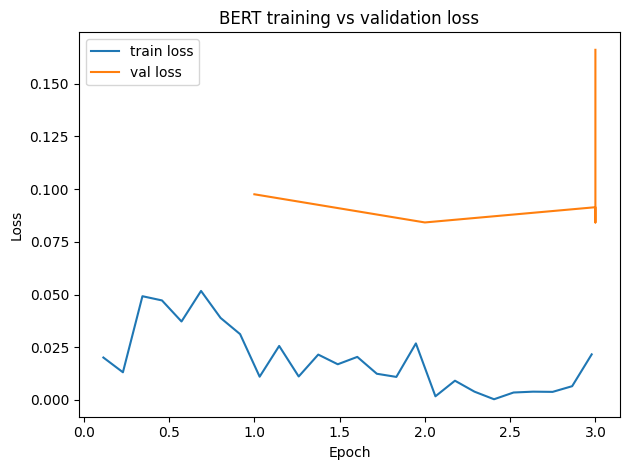

In [10]:
# Plot training and validation loss over epochs

import matplotlib.pyplot as plt

log_history = trainer.state.log_history

train_epochs = []
train_losses = []
eval_epochs = []
eval_losses = []

for entry in log_history:
    if "loss" in entry and "epoch" in entry and "eval_loss" not in entry:
        # training step
        train_epochs.append(entry["epoch"])
        train_losses.append(entry["loss"])
    if "eval_loss" in entry:
        # evaluation at end of epoch
        eval_epochs.append(entry["epoch"])
        eval_losses.append(entry["eval_loss"])

plt.figure()
if train_epochs:
    plt.plot(train_epochs, train_losses, label="train loss")
if eval_epochs:
    plt.plot(eval_epochs, eval_losses, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("BERT training vs validation loss")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

Above looks like overfit but we configured it to save the best epoch, so model at epoch 2 is saved.

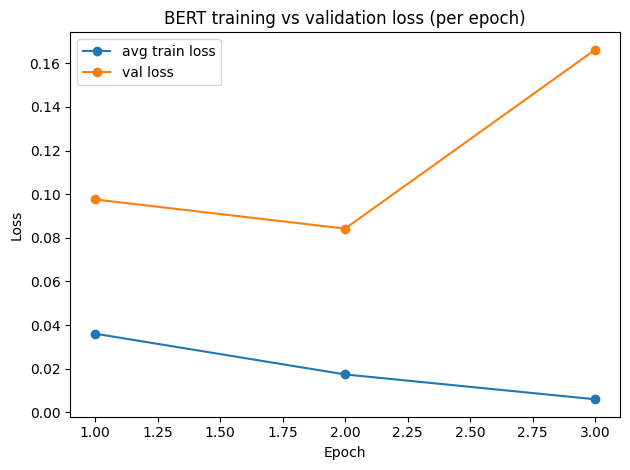

In [13]:
# Cleaner loss plot: average train loss per epoch vs eval loss per epoch (fixed)

import numpy as np
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

from collections import defaultdict

epoch_train_losses = defaultdict(list)
epoch_eval_losses = {}

for entry in log_history:
    # training steps
    if "loss" in entry and "epoch" in entry and "eval_loss" not in entry:
        e = int(np.floor(entry["epoch"])) + 1  # epochs start at 1
        epoch_train_losses[e].append(entry["loss"])
    # eval at end of epoch
    if "eval_loss" in entry and "epoch" in entry:
        e = int(round(entry["epoch"]))
        epoch_eval_losses[e] = entry["eval_loss"]

epochs = sorted(epoch_eval_losses.keys())

avg_train = [np.mean(epoch_train_losses[e]) for e in epochs]
eval_losses = [epoch_eval_losses[e] for e in epochs]

plt.figure()
plt.plot(epochs, avg_train, marker="o", label="avg train loss")
plt.plot(epochs, eval_losses, marker="o", label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("BERT training vs validation loss (per epoch)")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

	•	The overfitting only shows up at epoch 3, epoch 2 is still in the good region.
	•	The validation metrics at epoch 2 and 3 are both extremely strong and very close (F1 around 0.992). The loss bump looks big but the actual classification performance barely changes.
	•	Because we set load_best_model_at_end=True with metric_for_best_model="eval_f1", the trainer will keep the checkpoint with the best validation F1. So effectively we end up using the best epoch (likely epoch 2, or 3 if they tied in F1).

/Users/ramana/anaconda3/envs/fashion-bert/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 102/102 [00:14<00:00,  7.12it/s]
/Users/ramana/anaconda3/envs/fashion-bert/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 80/80 [00:10<00:00,  7.36it/s]


=== Validation (threshold = 0.50) ===
Classification report (0=non-fashion, 1=fashion):
              precision    recall  f1-score   support

           0     0.9463    0.9662    0.9562       474
           1     0.9942    0.9907    0.9925      2788

    accuracy                         0.9871      3262
   macro avg     0.9703    0.9785    0.9743      3262
weighted avg     0.9873    0.9871    0.9872      3262

Confusion matrix (rows=true, cols=pred):
[[ 458   16]
 [  26 2762]]


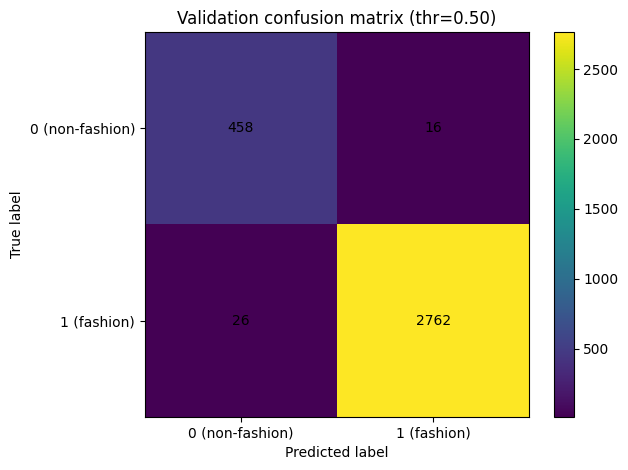


=== Test (threshold = 0.50) ===
Classification report (0=non-fashion, 1=fashion):
              precision    recall  f1-score   support

           0     0.9294    0.9169    0.9231       445
           1     0.9824    0.9852    0.9838      2099

    accuracy                         0.9733      2544
   macro avg     0.9559    0.9510    0.9535      2544
weighted avg     0.9731    0.9733    0.9732      2544

Confusion matrix (rows=true, cols=pred):
[[ 408   37]
 [  31 2068]]


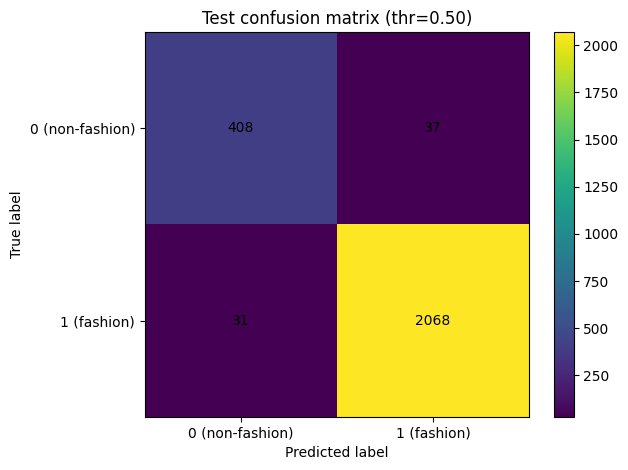

In [14]:
# BERT: confusion matrices on val and test (threshold = 0.5)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
)

# Helper: get logits and probs from Trainer
def get_probs_and_labels(dataset):
    preds_output = trainer.predict(dataset)
    logits = preds_output.predictions
    labels = preds_output.label_ids
    probs = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)  # softmax
    prob_fashion = probs[:, 1]  # probability of label 1 (fashion)
    return prob_fashion, labels

# Get probabilities and true labels
val_probs, val_labels = get_probs_and_labels(val_ds_tok)
test_probs, test_labels = get_probs_and_labels(test_ds_tok)

def eval_at_threshold(probs, labels, threshold, split_name):
    preds = (probs >= threshold).astype(int)

    print(f"\n=== {split_name} (threshold = {threshold:.2f}) ===")
    print("Classification report (0=non-fashion, 1=fashion):")
    print(classification_report(labels, preds, labels=[0, 1], digits=4))

    cm = confusion_matrix(labels, preds, labels=[0, 1])
    print("Confusion matrix (rows=true, cols=pred):")
    print(cm)

    # Plot confusion matrix
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"{split_name} confusion matrix (thr={threshold:.2f})")
    plt.colorbar()
    tick_labels = ["0 (non-fashion)", "1 (fashion)"]
    plt.xticks([0, 1], tick_labels)
    plt.yticks([0, 1], tick_labels)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    # annotate counts
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")

    plt.tight_layout()
    plt.grid(False)
    plt.show()


# Evaluate at default threshold 0.5
eval_at_threshold(val_probs, val_labels, 0.5, "Validation")
eval_at_threshold(test_probs, test_labels, 0.5, "Test")

In [15]:
# Threshold sweep on validation set for BERT

from sklearn.metrics import precision_recall_fscore_support

thresholds = np.linspace(0.50, 0.99, 17)  # 0.50, 0.53, ..., 0.99

print("Thresh | Prec_1  Recall_1  FP_for_1  FN_for_1")
print("-------+--------------------------------------")

val_labels_arr = np.array(val_labels)

sweep_rows = []

for thr in thresholds:
    preds = (val_probs >= thr).astype(int)

    # precision/recall for fashion (label 1)
    prec, rec, f1, _ = precision_recall_fscore_support(
        val_labels_arr, preds, average="binary", pos_label=1
    )

    cm = confusion_matrix(val_labels_arr, preds, labels=[0, 1])
    # rows: true 0,1; cols: pred 0,1
    # FP_for_1: true 0, predicted 1
    fp_for_1 = cm[0, 1]
    # FN_for_1: true 1, predicted 0
    fn_for_1 = cm[1, 0]

    sweep_rows.append((thr, prec, rec, fp_for_1, fn_for_1))

    print(
        f"{thr:5.2f}  | {prec:7.4f} {rec:8.4f} {fp_for_1:8d} {fn_for_1:9d}"
    )

# Optional: small DataFrame to inspect or plot later
import pandas as pd

sweep_df = pd.DataFrame(
    sweep_rows, columns=["threshold", "precision_1", "recall_1", "fp_for_1", "fn_for_1"]
)

Thresh | Prec_1  Recall_1  FP_for_1  FN_for_1
-------+--------------------------------------
 0.50  |  0.9942   0.9907       16        26
 0.53  |  0.9942   0.9907       16        26
 0.56  |  0.9942   0.9907       16        26
 0.59  |  0.9942   0.9907       16        26
 0.62  |  0.9942   0.9907       16        26
 0.65  |  0.9942   0.9907       16        26
 0.68  |  0.9942   0.9907       16        26
 0.71  |  0.9942   0.9907       16        26
 0.74  |  0.9942   0.9903       16        27
 0.78  |  0.9942   0.9900       16        28
 0.81  |  0.9942   0.9900       16        28
 0.84  |  0.9942   0.9900       16        28
 0.87  |  0.9942   0.9896       16        29
 0.90  |  0.9946   0.9892       15        30
 0.93  |  0.9946   0.9892       15        30
 0.96  |  0.9946   0.9892       15        30
 0.99  |  0.9946   0.9871       15        36


#### The 15–16 non-fashion items that BERT calls fashion are “hard mistakes” for this model. They have very high predicted probabilities, so pushing the threshold up doesn’t really fix them. Threshold tuning mostly just throws away a few more borderline fashion items; it doesn’t clean up those FPs

#### So our observation at this point is as follows 

	•	Logistic regression @ 0.84
	•	Pros: very low non-fashion → fashion contamination (2 val, 6 test).
	•	Cons: misses more fashion items (lower recall).
	•	BERT @ any reasonable threshold
	•	Pros: excellent overall accuracy and recall/f1, much better than logistic globally.
	•	Cons: still ~15–16 non-fashion → fashion on val and 37 on test; threshold doesn’t really shrink this.